# PLOT EDDY FROM AMEDA RESULTS 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, ticker, rcParams
from tqdm import tqdm
import scipy.interpolate as interp
import matplotlib
import matplotlib.colors as col #ListedColormap
#import matplotlib.path as mpp
import h5py  # For NEW Matlab files (AMEDA)
import scipy.io as sio # For OLD Matlab files
rcParams['pcolor.shading']='auto'

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature


In [2]:
#general parameters
Npts=50 ## number of points for contour interpolation
step=-1 #last time step
last=3

In [3]:
path_ameda='/home/shom_simuref/CROCO/ODC/SIMU-RESULT/HINDCAST_2012_2013/OUTPUTS_AMEDA/EDDY_2012_2013/'

In [4]:
path_model=f'{path_ameda}/../inputs'

In [5]:
def read_data(file,var):
    data=xr.open_dataset(file)
    return data[var]

In [6]:
def change_coordinates(var,lon,lat):
    var=var.assign_coords({"X":lon[0,:], "Y":lat[:,0]})
    #if "xi_rho" in list(var.coords):
    var=var.swap_dims({"xi_rho":"X","eta_rho":"Y"})
    return var

In [7]:
#read grid
ds_grid=xr.open_dataset('/home/shom_simuref/CROCO/ODC/CONFIGS/MEDITERRANEE_GLOBALE/CROCO_FILES/test2.nc')
mask=ds_grid.mask_rho
lon=ds_grid.lon_rho
lat=ds_grid.lat_rho
mask=change_coordinates(mask,lon,lat)

In [8]:
#read model
ssh=read_data(f'{path_model}/MED_ssh.nc','zeta')
ugeos=read_data(f'{path_model}/MED_ugeo.nc','ugeo')
vgeos=read_data(f'{path_model}/MED_vgeo.nc','vgeo')
#set coordinates
ssh=change_coordinates(ssh,lon,lat)
ugeos=xr.DataArray(ugeos.data,coords=ssh.coords,dims=ssh.dims)
vgeos=xr.DataArray(vgeos.data,coords=ssh.coords,dims=ssh.dims)


In [9]:
## Param_eddy_tracking
params_dict = sio.loadmat(path_ameda+'param_eddy_tracking.mat')
deg=int(params_dict['deg']) ; resol=int(params_dict['resol'])

In [10]:
## Grid
gridname='/home/shom_simuref/CROCO/ODC/CONFIGS/MEDITERRANEE_GLOBALE/CROCO_FILES/test2.nc'
#x_am=grid_dict['x'] ; y_am=grid_dict['y']
## Shapes
D = h5py.File(path_ameda+'eddy_shapes.mat','r')  ## Or tracks2.mat ??
shapes=D['shapes1']
Nst=shapes['step'].shape[0]
print(str(Nst)+' time steps')

4 time steps


In [11]:
tmax=shapes['velmax'].shape[0]
steps=np.arange(1,tmax+1)
Ned=D[shapes['xy'][step,0]].shape[0]#[10,0]][:] # eddy number at last time step
Neds=[]
#read from the tlast before last one
for t in range(-last,step+1):
    Neds+=[D[shapes['xy'][t,0]].shape[0]]
    print(str(Neds[-1])+' detected eddies at time step t='+str(steps[t]))
Nmax=np.max(Neds) ; Nstep=len(Neds) ; Nstep
print(str(Nstep)+' steps')

229 detected eddies at time step t=2
223 detected eddies at time step t=3
208 detected eddies at time step t=4
3 steps


In [12]:
#read last time step t0
shapes_inter0=np.zeros((Ned,2, Npts))
shapes_end_inter0=np.zeros((Ned,2, Npts))
Vort=D[shapes['vort'][step,0]][:]
for e in tqdm(range(Ned)):
    x_data=D[D[shapes['xy'][step,0]][e,0]][:,0]    ### Rmax
    y_data=D[D[shapes['xy'][step,0]][e,0]][:,1]
    ix=np.linspace(0,len(x_data)-1,Npts)
    shapes_inter0[e,0]=interp.interp1d(np.arange(len(x_data)), x_data)(ix)
    shapes_inter0[e,1]=interp.interp1d(np.arange(len(x_data)), y_data)(ix)
    
    x_data=D[D[shapes['xy_end'][step,0]][e,0]][:,0]     ### End contour
    y_data=D[D[shapes['xy_end'][step,0]][e,0]][:,1]
    ix=np.linspace(0,len(x_data)-1,Npts)
    shapes_end_inter0[e,0]=interp.interp1d(np.arange(len(x_data)), x_data)(ix)
    shapes_end_inter0[e,1]=interp.interp1d(np.arange(len(x_data)), y_data)(ix)

100%|██████████| 208/208 [00:01<00:00, 180.25it/s]


100%|██████████| 208/208 [00:00<00:00, 811.46it/s]


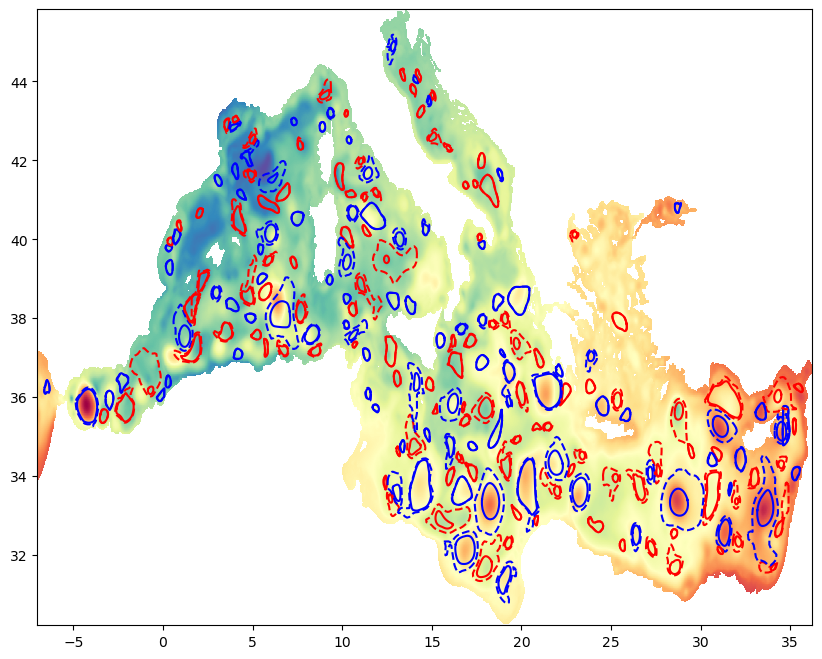

In [13]:
#plot

ssh2=ssh.isel(time=step).where(mask)
u=ugeos.isel(time=step).where(mask==1)
v=vgeos.isel(time=step).where(mask==1)
u=u.where(np.abs(u)<2)
v=v.where(np.abs(v)<2)
plt.figure(0, figsize=(10,8))


CP1=plt.pcolormesh(lon, lat, ssh2.data, cmap=cm.Spectral_r)#, vmin=19, vmax=30)
#QV1=plt.quiver(lon, lat, u.data, v.data)
#plt.quiverkey(QV1,1,44,1,' 1 m/s [1/8 geos]',coordinates='data',fontproperties={'size':18})
for e in tqdm(range(Ned)):
    if Vort[e]<0:
        color='b'
    else:
        color='r'
    plt.plot(shapes_inter0[e,0],shapes_inter0[e,1],'-',color=color)
    plt.plot(shapes_end_inter0[e,0],shapes_end_inter0[e,1],'--',color=color)

In [14]:
def plot_eddies(ax):
    for e in tqdm(range(Ned)):
     if Vort[e]<0:
        color='b'
     else:
        color='r'
     ax.plot(shapes_inter0[e,0],shapes_inter0[e,1],'-',transform=src_proj,color=color)
     ax.plot(shapes_end_inter0[e,0],shapes_end_inter0[e,1],'--',transform=src_proj,color=color) 
    return ax

In [15]:
#set map projection
proj=ccrs.LambertConformal(central_latitude=38,central_longitude=15)
#projection of the data
src_proj=ccrs.PlateCarree()
#set colormap
cmap = cm.Spectral_r

In [39]:
def plot_data(lon,lat,u,v,vol,ax,title):
    #get max data for quiverkey 
    maxdata=vol.max()
    print('max',maxdata)
    #plot parameters
    #levels=np.arange(0,maxdata,int(maxdata/15))
    #norm = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    #kwargs_plot=dict(norm=norm,transform=src_proj,cmap=cmap)
    kwargs_plot=dict(transform=src_proj,cmap=cmap)

    #do the background plot with volume
    cf=ax.pcolormesh(lon,lat,vol.data,**kwargs_plot)
    
    #set extent 
    ax.set_extent([-6,10,35.5,43],crs=ccrs.PlateCarree())
    
    #set coastline , land and grid labels
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='k')
    gl=ax.gridlines(draw_labels=True,x_inline=False, y_inline=False)
    gl.xlines=False
    gl.ylines=False
    gl.top_labels=False
    gl.right_labels=False

    #do quiver plot
    Q=ax.quiver(x=lon.data,y=lat.data,u=u.data,v=v.data,transform=src_proj,regrid_shape=40)
    #mean_trans=np.ma.sqrt(u**2+v**2)
    #mtrans=mean_trans.max().round(2)
    #qk=ax.quiverkey(Q,0.2,0.8,mtrans,f"{mtrans} $m.s^-1$",labelpos="N")
   
    #set colorbar
    col=fig.colorbar(cf,ax=ax,extend='both',shrink=0.5,label='m')
    #time
    date=vol.time.dt.strftime('%d/%m/%Y %H:%M').data
    #
    ax=plot_eddies(ax)
    #set title
    ax.set_title(f'{title} - {date}')
    return ax,cf

max <xarray.DataArray 'zeta' ()>
array(-0.14964348)
Coordinates:
    time     datetime64[ns] 2013-06-30T11:58:00


100%|██████████| 208/208 [00:00<00:00, 238.60it/s]


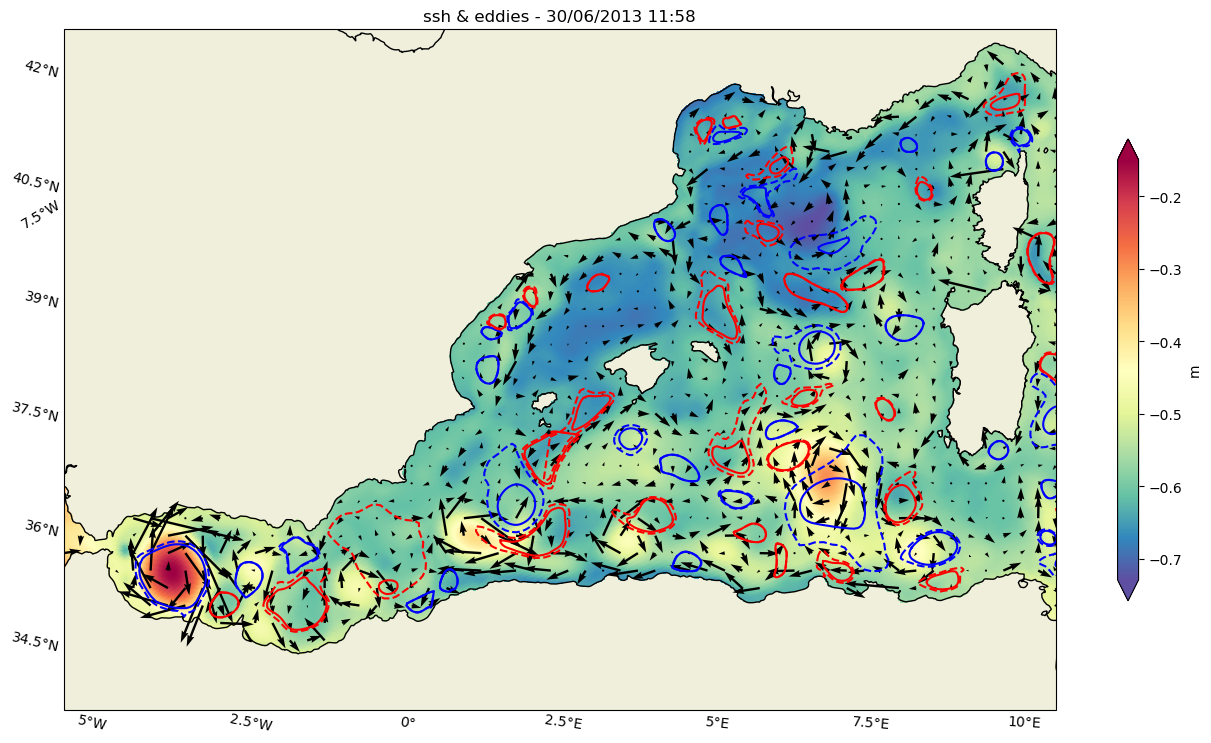

In [41]:
fig,ax=plt.subplots(1,1,figsize=(16, 12),subplot_kw=dict(projection=proj))
ax,cf=plot_data(lon,lat,u,v,ssh2,ax,"ssh & eddies")
plt.savefig('ameda_eddies.png', bbox_inches='tight')

In [18]:
date=ssh2.time.dt.strftime('%d/%m/%Y %H:%M')

In [19]:
plt.savefig('ameda_eddies.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>